In [ ]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
class SimpleAutoEncoder(nn.Module):
  def __init__(self, feature_size=2):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(64, 64, 3, 2, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.LeakyReLU(inplace=True)
    )

    self.encoder_fc = nn.Linear(7*7*64, feature_size)
    self.decoder_fc = nn.Linear(feature_size, 7*7*64)

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 64, 3, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(64, 64, 3, 2, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(32, 1, 3, 1, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # Encoding
    x = self.encoder(x)
    x = torch.flatten(x, 1)
    x = self.encoder_fc(x)

    # Decoding
    x = self.decoder_fc(x)
    x = x.view(-1, 64, 7, 7)
    x = self.decoder(x)
    return x

In [ ]:
feature_size = 2
lr = 0.0005
batch_size = 64
nrof_epochs = 30
loss_fn_name = "rmse"
device = "cuda"
model_path = "./drive/My Drive/model.pt"
transformations = transforms.Compose([
  transforms.ToTensor()
])

True
/content


In [ ]:
train_dataset = MNIST(
    root="./",
    train=True,
    transform=transformations,
    download=True
)

test_dataset = MNIST(
    root="./",
    train=False,
    transform=transformations,
    download=True
)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=16,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=16,
    drop_last=True
)

In [ ]:
model = SimpleAutoEncoder(feature_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [15, 25, 28])

loss_fn = {
    "mse": nn.MSELoss(),
    "rmse": nn.MSELoss(),
    "cross-entropy": nn.CrossEntropyLoss()
}[loss_fn_name]

In [ ]:
if Path(model_path).exists():
  model.load_state_dict(torch.load(model_path))
else:
  model.train()
  for epoch in range(nrof_epochs):
    loss = 0.
    for i_batch, (x, _) in enumerate(train_loader):
      x = x.to(device)
      x_pred = model(x)
      
      loss_batch = loss_fn(x_pred, x)
      if loss_fn_name == "rmse":
        loss_batch = torch.sqrt(loss_batch)

      optimizer.zero_grad()
      loss_batch.backward()
      optimizer.step()

      loss += loss_batch
      # if i_batch % 20 == 0:
      #   print(f"Batch {i_batch}/{len(train_loader)} | Loss {loss.item()/(i_batch+1)}")
    scheduler.step()
    loss = loss / (i_batch + 1)
    print(f"Epoch {epoch+1}/{nrof_epochs} | Loss {loss.item()}")

Epoch 1/30 | Loss 0.23072104156017303
Epoch 2/30 | Loss 0.210272416472435
Epoch 3/30 | Loss 0.20535600185394287
Epoch 4/30 | Loss 0.2025502324104309
Epoch 5/30 | Loss 0.20056846737861633
Epoch 6/30 | Loss 0.19898203015327454
Epoch 7/30 | Loss 0.1978181004524231
Epoch 8/30 | Loss 0.19679304957389832
Epoch 9/30 | Loss 0.19598054885864258
Epoch 10/30 | Loss 0.1953481286764145
Epoch 11/30 | Loss 0.19456757605075836
Epoch 12/30 | Loss 0.1941194385290146
Epoch 13/30 | Loss 0.1936521679162979
Epoch 14/30 | Loss 0.19313427805900574
Epoch 15/30 | Loss 0.1925932914018631
Epoch 16/30 | Loss 0.18994678556919098
Epoch 17/30 | Loss 0.1894529014825821
Epoch 18/30 | Loss 0.18926294147968292
Epoch 19/30 | Loss 0.18910618126392365
Epoch 20/30 | Loss 0.1889709234237671
Epoch 21/30 | Loss 0.18885517120361328
Epoch 22/30 | Loss 0.18872468173503876
Epoch 23/30 | Loss 0.18863657116889954
Epoch 24/30 | Loss 0.18852394819259644
Epoch 25/30 | Loss 0.18844789266586304
Epoch 26/30 | Loss 0.18805989623069763
Epoch

In [ ]:
model.eval()
loss = 0.
for i_batch, (x, _) in enumerate(test_loader):
  x = x.to(device)
  x_pred = model(x)
    
  loss_batch = loss_fn(x_pred, x)
  if loss_fn_name == "rmse":
    loss_batch = torch.sqrt(loss_batch)
  loss += loss_batch

loss = loss / (i_batch + 1)
print(f"Test set lost: {loss.item()}")

Test set lost: 0.19104519486427307


In [ ]:
torch.save(model.state_dict(), "./model.pt")

In [ ]:
def rescale(x):
  x = x - np.min(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
  x = x / np.max(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
  return (x*255).astype(np.uint8)


def torch_to_numpy(x):
  x = x.detach().cpu().numpy()
  x = x.transpose(0, 2, 3, 1)
  x = rescale(x)
  return x

def make_samples_grid(x, x_pred=None, grid_shape=6*6):
  x = torch_to_numpy(x)
  if x_pred is not None:
    x_pred = torch_to_numpy(x_pred)
  
  n = 2 if x_pred is not None else 1

  H, W = x.shape[1:3]
  m = int(np.sqrt(grid_shape))
  grid = np.zeros((H*m, W*m), dtype=np.uint8)

  i = 0
  for row in range(m):
    for col in range(m):
      sample = [x, x_pred][i%n]
      grid[H*row:H*(row+1), W*col:W*(col+1)] = sample[int(i//n)][..., 0]
      i += 1
  return grid

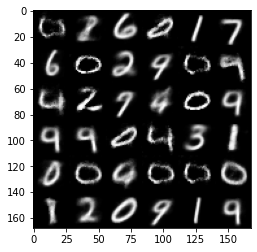

In [ ]:
indices = np.arange(len(test_dataset))
np.random.shuffle(indices)

x = []
y = []
for index in indices:
  image, label = test_dataset[index]
  x.append(image)
  y.append(label)

x = torch.stack(x)
x = x.to(device)
x_pred = model(x)
random = np.sqrt(10)*torch.randn((36, 2))
random = random.to(device)
decoder_input = model.decoder_fc(random)
decoder_input = decoder_input.view(-1, 64, 7, 7)
x_pred = model.decoder(decoder_input)

grid = make_samples_grid(x_pred)

plt.imshow(grid, cmap="gray")
plt.show()

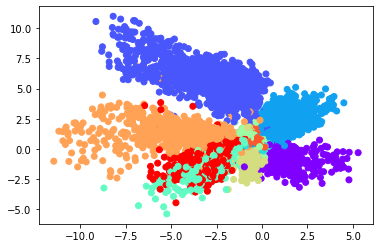

In [ ]:
encoded = model.encoder(x)
encoded = torch.flatten(encoded, 1)
representation = model.encoder_fc(encoded)

representation = representation.detach().cpu().numpy() # 512, 2

x1 = representation[:, 0]
x2 = representation[:, 1]
colors = cm.rainbow(np.linspace(0, 1, 10))
colors = [colors[label] for label in y]

plt.scatter(x1, x2, color=colors)